# GPU Computing with CuPy

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
# cp.cuda.set_allocator(None) # You can disable CuPy memory pool with this 
%load_ext Cython

In [2]:
from contextlib import contextmanager
from time import time

@contextmanager
def cupy_timer():
    start = cp.cuda.Event()
    end = cp.cuda.Event()
    start.record()
    yield
    end.record()
    end.synchronize()
    elapsed_time = cp.cuda.get_elapsed_time(start, end)
    print(f'Elapsed time: {elapsed_time} ms')
    

@contextmanager
def cpu_timer():
    start = time()
    yield
    end = time()
    print(f'Elapsed time: {(end - start) * 1000} ms')

## Matrix Multiplication NumPy vs CuPy

In [3]:
x_cpu = np.random.random((1000, 1000))
y_cpu = np.random.random((1000, 1000))
x_gpu = cp.array(x_cpu)
y_gpu = cp.array(y_cpu)

with cpu_timer():
    z_cpu = x_cpu @ y_cpu

with cupy_timer():
    z_gpu = x_gpu @ y_gpu

Elapsed time: 26.75008773803711 ms
Elapsed time: 154.8260498046875 ms


## Linear System Solving NumPy vs CuPy

In [4]:
A_cpu = np.random.random((1000, 1000))
b_cpu = np.random.random(1000)
A_gpu = cp.array(A_cpu)
b_gpu = cp.array(b_cpu)
with cpu_timer():
    np.linalg.solve(A_cpu, b_cpu)
    
with cupy_timer():
    cp.linalg.solve(A_gpu, b_gpu)

Elapsed time: 28.655290603637695 ms
Elapsed time: 286.1148681640625 ms


## Euclidean distance matrix

$
    d_e(\mathbf x, \mathbf y) =
    \begin{bmatrix}
    \sum_{i=1}^n (x_{1i}-y_{1i})^2 & \sum_{i=1}^n(x_{1i}-y_{2i})^2 & \cdots & \sum_{i=1}^n (x_{1i}-y_{ni})^2 \\  
    \sum_{i=1}^n(x_{2i}-y_{1i})^2 & \sum_{i=1}^n(x_{2i}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{2i}-y_{ni})^2 \\  
    \vdots & \vdots & \ddots & \vdots \\
    \sum_{i=1}^n(x_{ni}-y_{1i})^2 & \sum_{i=1}^n(x_{ni}-y_{2i})^2 & \cdots & \sum_{i=1}^n(x_{ni}-y_{ni})^2 \\  
    \end{bmatrix}
$

## Vectorization friendly summation 
$ 
\sum_{k=1}^n \left(x_{ik}-y_{ik}\right)^2 = \left(\vec{x_i} - \vec {y_j}\right)\cdot \left(\vec{x_i} - \vec{y_j}\right)=\vec{x_i} \cdot \vec{x_i} + \vec{y_j} \cdot \vec{y_j} \cdot \vec{y_j}-2\vec{x_i}\cdot \vec{y_j}$


In [5]:
def euclidean_distance_cpu(x, y):
    x2 = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    y2 = np.einsum('ij,ij->i', y, y)[:, np.newaxis].T
    xy = x @ y.T
    return np.abs(x2 + y2 - 2.0 * xy)

In [6]:
def euclidean_distance_gpu(x, y):
    x2 = cp.einsum('ij,ij->i', x, x)[:, cp.newaxis]
    y2 = cp.einsum('ij,ij->i', y, y)[:, cp.newaxis].T
    xy = x @ y.T
    return cp.abs(x2 + y2 - 2.0 * xy)

In [7]:
x_cpu = np.random.random((5000, 5000))
y_cpu = np.random.random((5000, 5000))
x_gpu = cp.array(x_cpu)
y_gpu = cp.array(y_cpu)

with cpu_timer():
    eu_cpu = euclidean_distance_cpu(x_cpu, y_cpu)

with cupy_timer():
    eu_gpu = euclidean_distance_gpu(x_gpu, y_gpu)
    
print(np.allclose(eu_cpu, eu_gpu.get()))

Elapsed time: 5042.825937271118 ms
Elapsed time: 5424.3798828125 ms
True


## Make function work for both CuPy/NumPy 

In [8]:
def euclidean_distance(x, y):
    modp = cp.get_array_module(x)
    x2 = modp.einsum('ij,ij->i', x, x)[:, modp.newaxis]
    y2 = modp.einsum('ij,ij->i', y, y)[:, modp.newaxis].T
    xy = x @ y.T
    return modp.abs(x2 + y2 - 2.0 * xy)

In [9]:
with cpu_timer():
    eu_cpu = euclidean_distance(x_cpu, y_cpu)

with cupy_timer():
    eu_gpu = euclidean_distance(x_gpu, y_gpu)
    
print(np.allclose(eu_cpu, eu_gpu.get()))

Elapsed time: 4605.071067810059 ms
Elapsed time: 5399.51513671875 ms
True


## Calculating/Plotting Julia Sets

In [10]:
%%cython

# distutils: extra_compile_args = -fopenmp -march=native
# distutils: extra_link_args = -fopenmp
from cython cimport boundscheck, wraparound
from cython.parallel cimport prange

@boundscheck(False)
@wraparound(False)
def julia_set_cython(const double[:, :] X, const double[:, :] Y,
                     const double cx, const double cy,
                     const int iter_max, const double radius2, 
                     int[:, :] julia):
    cdef:
        int i, j, k, nx, ny
        double x, y
    nx = X.shape[0]
    ny = Y.shape[1]
    for i in prange(nx, nogil=True, schedule='static'):
        for j in range(ny):
            x = X[i, j]
            y = Y[i, j]
            k = 0
            while x * x + y * y < radius2 and k < iter_max:
                x, y = x * x - y * y + cx, 2.0 * x * y + cy
                k = k + 1
                
            julia[i, j] = k 

Elapsed time: 217.8494930267334 ms


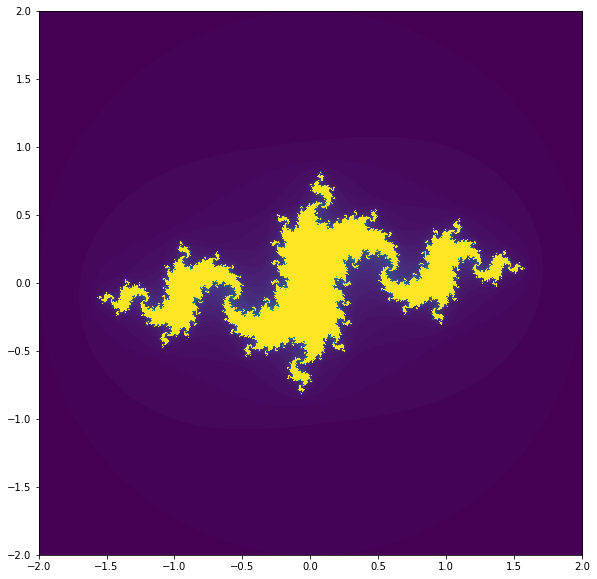

In [13]:
X, Y = np.meshgrid(np.linspace(-2.0 , 2.0, 5000), np.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
julia = np.zeros_like(X, dtype=np.int32)
c = -0.9 + 0.22143j
radius2 = 4.0
with cpu_timer():
    julia_set_cython(X, Y, c.real, c.imag, 100, radius2, julia)
ax.set_aspect('equal')
ax.imshow(julia, extent=[-2, 2, -2, 2]);

### Elementwise Kernel

In [14]:
julia_kernel = cp.ElementwiseKernel('float64 X, float64 Y, float64 cx, float64 cy, int32 itermax, float64 radius2',
                                    'int32 julia',
                                    f'''julia = 0;
                                    double x = X, y = Y;
                                    double xtemp;
                                    int nit = 0;
                                    while(x * x + y * y < radius2 && nit < itermax) {{
                                        xtemp = x * x - y * y + cx;
                                        y = 2.0 * x * y + cy;
                                        x = xtemp;
                                        nit += 1;
                                    }}
                                    julia = nit;''', 'julia_kernel')

Elapsed time: 76.67100524902344 ms


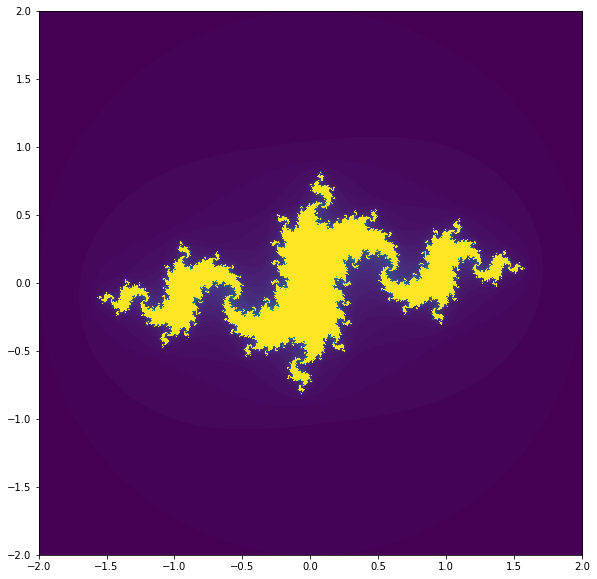

In [15]:
X, Y = cp.meshgrid(cp.linspace(-2.0 , 2.0, 5000), cp.linspace(-2.0, 2.0, 5000))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
c = -0.9 + 0.22143j
with cupy_timer():
    julia_gpu = julia_kernel(X, Y, c.real, c.imag, 100, 4.0)
    julia_array = julia_gpu.get()
ax.set_aspect('equal')
ax.imshow(julia_array, extent=[-2, 2, -2, 2]);

### Raw Kernel

In [39]:
julia_rawkernel = cp.RawKernel(r'''
        extern "C" 
        __global__ void julia_rawkernel(const double* X, const double* Y, const double cx,
                              const double cy, const int itermax, const int nx,
                              const int ny, const double radius, int* julia)  {
        int tidx = blockDim.x * blockIdx.x + threadIdx.x;
        int tidy = blockDim.y * blockIdx.y + threadIdx.y;
        int niter = 0;
        double tempx;
        if(tidx < nx && tidy < ny) 
        {
            int tid = tidy * nx + tidx;
            double x = X[tid], y = Y[tid];
            while((x * x + y * y) < (radius * radius) && niter < itermax) {
                tempx = x * x - y * y + cx;
                y = 2.0 * x * y + cy;
                x = tempx;
                niter +=1 ;
            }
            julia[tid] = niter;
        }
    }''', 'julia_rawkernel')

Elapsed time: 79.11894226074219 ms


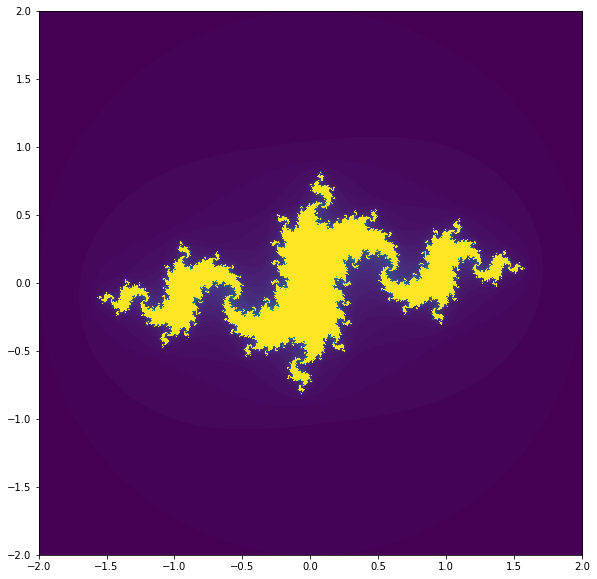

In [40]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
c = -0.9 + 0.22143j
threads_x = 32
threads_y = 32
x_points = 5000
y_points = 5000
x_blocks = (x_points - 1) // threads_x + 1 
y_blocks = (y_points - 1) // threads_y + 1
X_gpu, Y_gpu = cp.meshgrid(cp.linspace(-2.0 , 2.0, x_points), cp.linspace(-2.0, 2.0, y_points))
with cupy_timer():
    julia_gpu = cp.zeros_like(X_gpu, dtype=cp.int32)
    julia_rawkernel((x_blocks, y_blocks), (threads_x, threads_y), (X_gpu, Y_gpu, c.real, c.imag, 100, 
                    x_points, y_points, 2.0, julia_gpu))
    julia_array = julia_gpu.get()
ax.imshow(julia_array, extent=[-2, 2, -2, 2]);

## CuPy Memory Pools 

In [26]:
!nvidia-smi #

Wed Nov  6 15:07:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970     Off  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P5    20W / 163W |   2081MiB /  4039MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [27]:
%whos 

Variable                 Type                          Data/Info
----------------------------------------------------------------
A_cpu                    ndarray                       1000x1000: 1000000 elems, type `float64`, 8000000 bytes (7.62939453125 Mb)
A_gpu                    ndarray                       1000x1000: 1000000 elems, type `float64`, 8000000 bytes (7.62939453125 Mb)
X                        ndarray                       5000x5000: 25000000 elems, type `float64`, 200000000 bytes (190.73486328125 Mb)
X_gpu                    ndarray                       5000x5000: 25000000 elems, type `float64`, 200000000 bytes (190.73486328125 Mb)
Y                        ndarray                       5000x5000: 25000000 elems, type `float64`, 200000000 bytes (190.73486328125 Mb)
Y_gpu                    ndarray                       5000x5000: 25000000 elems, type `float64`, 200000000 bytes (190.73486328125 Mb)
ax                       AxesSubplot                   AxesSubplot(0.1

In [20]:
mempool = cp.get_default_memory_pool()

In [42]:
used_gbs = mempool.used_bytes() / 1024 ** 3
total_gbs = mempool.total_bytes() / 1024 ** 3
print(f'Memory pool uses: {used_gbs:.3f} out of {total_gbs:.3f} GB')

Memory pool uses: 1.412 out of 2.003 GB
